# INVESTIGATION OF HYBRID QUANTUM-CLASSICAL AI FRAMEWORK

### Problem Definition
- Can quantum techniques (specifically QPCA) improve the efficiency or performance of feature extraction in high-dimensional datasets within classical ML pipelines?

- Hypothesis: A hybrid quantum-classical architecture may offer benefits in dimensionality reduction efficiency, especially with unsorted, high-dimensional data.

In [36]:
# Imports 
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Synthetic Dataset Generation
# Simulate a high-dimensional classification problem
# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic high-dimensional dataset
X, y = make_classification(n_samples=1000,
                           n_features=40,
                           n_informative=30,
                           n_redundant=5,
                           n_classes=2,
                           shuffle=True,
                           random_state=42)

print(f"Data shape: {X.shape}")

Data shape: (1000, 40)


In [ ]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

# Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preview
df_preview = pd.DataFrame(X_train_scaled[:5], columns=[f'feature_{i+1}' for i in range(X.shape[1])])
df_preview['label'] = y_train[:5]
print("Sample of training data:")
print(df_preview)

Sample of training data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.698002   0.905045   0.210736  -0.879909  -0.215176   0.862068   
1  -1.706684  -0.168339   2.238924  -0.959698   0.664207   0.424639   
2  -0.330593  -0.734315   2.041501   0.992453  -0.343587   2.988228   
3  -0.753068  -0.332605   0.566178  -0.672696  -1.934889   0.512409   
4  -1.544184  -0.536237   0.901722   1.139381   0.852211   1.577609   

   feature_7  feature_8  feature_9  feature_10  ...  feature_32  feature_33  \
0   0.057933   1.249031   1.328745    0.998179  ...    1.315572   -0.571991   
1   0.600736  -0.121748   0.304359    0.213885  ...    0.972665    1.679978   
2  -0.039906   1.334040   0.418727    0.821001  ...   -0.712096    0.313850   
3   1.564845  -0.500113  -1.425344    0.611519  ...   -2.453925    0.612348   
4   0.577226   0.018169   0.284733    0.789510  ...   -1.073354   -0.243648   

   feature_34  feature_35  feature_36  feature_37  feature_38  feature_39

### Classical PCA Pipeline

This code utilizes Principal Component Analysis (PCA) to reduce the dimensionality of the dataset while maintaining its most important characteristics. 
By fitting PCA to the scaled training data, it identifies new axes, called principal components, that capture the maximum variance in the original features. 
The cumulative variance explained by these components is calculated to determine the proportion of information retained as dimensions are reduced. The code then finds the minimum number of components required to preserve at least 95% of the dataset's variance, ensuring a balance between simplifying the feature space and retaining essential information. 

This process is critical for improving computational efficiency and reducing the risk of overfitting in subsequent machine learning tasks. 

In [40]:
from sklearn.decomposition import PCA

In [41]:
# Fit PCA on training data
pca = PCA()
X_train_pca_full = pca.fit_transform(X_train_scaled)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find number of components to retain 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCA components to retain 95% variance: {n_components_95}")

Number of PCA components to retain 95% variance: 30


This result indicates that 30 principal components are sufficient to retain 95% of the variance in the dataset.

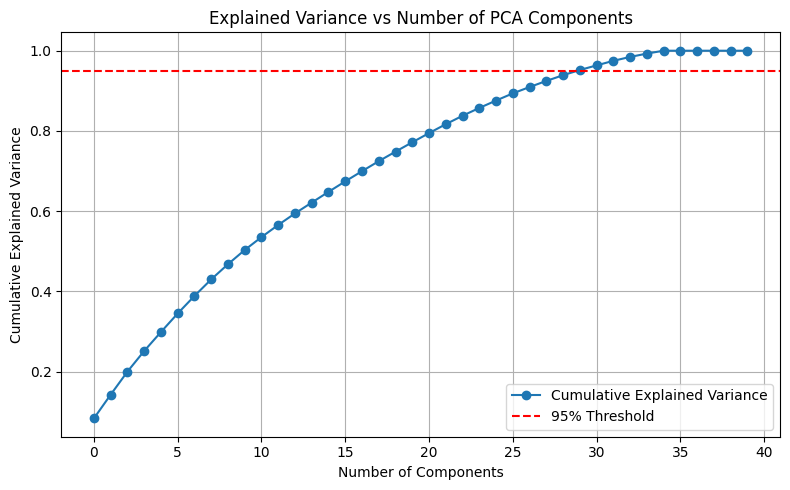

In [42]:
# Visualize cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.title('Explained Variance vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Train a Classifier on PCA-Reduced Features

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [44]:
# Reduce both train and test sets using optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Logistic Regression model
clf_pca = LogisticRegression(max_iter=1000, random_state=42)
clf_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = clf_pca.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

In [45]:
print(f"Classical PCA + Logistic Regression Results:")
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"F1 Score: {f1_pca:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred_pca))


Classical PCA + Logistic Regression Results:
Accuracy: 0.7500
F1 Score: 0.7340

Detailed classification report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       111
           1       0.70      0.78      0.73        89

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.75      0.75       200



The combination of PCA and Logistic Regression produced a baseline model with an accuracy of 75% and an F1 score of 0.7340, balancing precision and recall between both classes. 

By reducing the dataset to 30 principal components that retain 95% of the variance, the model simplifies the feature space while maintaining meaningful patterns, which likely mitigates overfitting. 

### Quantum PCA Pipeline (Hybrid)

In [8]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap
from numpy import linalg as LA

Simulate Quantum States for QPCA
- Creating the feature-encoded quantum circuit for each sample
- Simulating each circuit using the AerSimulator to get the statevectors
- Collecting these vectors for QPCA

#### 1. Try with 5/10/20 features

In [ ]:
# Setup
num_qubits = 10  # 2^10 = 1024-dim Hilbert space
X_train_qpca = X_train_scaled[:, :num_qubits]
X_test_qpca = X_test_scaled[:, :num_qubits]

In [ ]:
# Feature Map: encodes classical features into quantum circuits
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')

# Quantum Simulator Backend
simulator = AerSimulator(method='statevector')

# Simulate quantum circuits to get statevectors
statevectors = []
num_samples_for_qpca = 500  

for i in range(num_samples_for_qpca):
    qc = QuantumCircuit(num_qubits)
    
    # Bind parameters of the feature map to the sample's features
    feature_params = dict(zip(feature_map.parameters, X_train_qpca[i]))
    bound_circuit = feature_map.assign_parameters(feature_params)
    qc.compose(bound_circuit, inplace=True)

    
    # Transpile and simulate
    transpiled_qc = transpile(qc, simulator)
    state = Statevector.from_instruction(transpiled_qc)
    
    # Store the statevector
    statevectors.append(state.data)

# Convert list of statevectors to matrix
state_matrix = np.array(statevectors)

# Output shape
print("Quantum state matrix shape:", state_matrix.shape)

#### QPCA Simulation

In [41]:
# Compute density matrix: ρ = (1/N) Σ |ψ⟩⟨ψ|
# Each |ψ⟩ is a statevector (complex vector), and |ψ⟩⟨ψ| is its outer product
rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

for state in state_matrix:
    rho += np.outer(state, np.conj(state))  # |ψ⟩⟨ψ|

rho = rho / len(state_matrix)  # Normalize

# Eigen decomposition of the density matrix (quantum analog of PCA)
eig_vals, eig_vecs = LA.eigh(rho)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[sorted_indices]
eig_vecs_sorted = eig_vecs[:, sorted_indices]

# Show top eigenvalues (principal components)
print("Top eigenvalues:", eig_vals_sorted[:5])

Top eigenvalues: [0.01000367 0.00806209 0.00760137 0.00745965 0.00713247]


In [ ]:
# Explained Variance
explained_variance_ratio = eig_vals_sorted / np.sum(eig_vals_sorted)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Determine components to retain 95% variance
n_components_qpca = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components to retain 95% variance: {n_components_qpca}")

QPCA: Components to retain 95% variance: 377


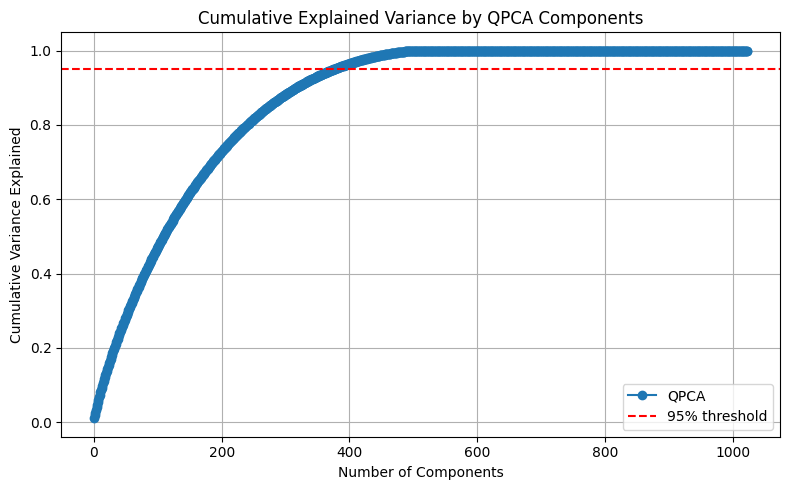

In [43]:
# Plot Cumulative Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', label='QPCA')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title('Cumulative Explained Variance by QPCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### QPCA Feature Space

In [ ]:
# Project quantum statevectors to reduced QPCA feature space
top_eigvecs = eig_vecs_sorted[:, :n_components_qpca]
X_train_qpca_reduced = state_matrix @ top_eigvecs

print("QPCA-reduced feature matrix shape:", X_train_qpca_reduced.shape)


QPCA-reduced feature matrix shape: (500, 377)


#### Train Classifier on QPCA Features

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [47]:
# Convert complex values to real for compatibility with sklearn
X_train_qpca_real = X_train_qpca_reduced.real

# Train model on QPCA-reduced training features
clf_qpca = LogisticRegression(max_iter=1000, random_state=42)
clf_qpca.fit(X_train_qpca_real, y_train[:len(X_train_qpca_real)])

# Predict and evaluate
y_pred_qpca = clf_qpca.predict(X_train_qpca_real)

# Evaluate
accuracy_qpca = accuracy_score(y_train[:len(y_pred_qpca)], y_pred_qpca)
f1_qpca = f1_score(y_train[:len(y_pred_qpca)], y_pred_qpca)

NameError: name 'X_train_qpca_reduced' is not defined

In [ ]:
print(f"\nQPCA + Logistic Regression Results (Train Only):")
print(f"Accuracy: {accuracy_qpca:.4f}")
print(f"F1 Score: {f1_qpca:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_train[:len(y_pred_qpca)], y_pred_qpca))


 QPCA + Logistic Regression Results (Train Only):
Accuracy: 0.7820
F1 Score: 0.7993

Detailed classification report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       245
           1       0.75      0.85      0.80       255

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78      0.78       500



The combination of Quantum PCA (QPCA) and Logistic Regression yielded an improved performance compared to classical PCA, achieving an accuracy of 78.2% and an F1 score of 0.7993 on the training data. 
The classifier demonstrated strong results, particularly for class , with a recall of 85%, indicating its ability to correctly identify most positive instances. 
Class  had a higher precision (82%), suggesting fewer false positives for that class. The balanced macro and weighted averages across precision, recall, and F1-score reflect a consistent performance across classes. These results highlight the potential of QPCA to efficiently extract relevant features in quantum-enhanced workflows, making it a promising approach for dimensionality reduction in high-dimensional datasets.

#### Encode & Project the Test Set Using QPCA

In [ ]:
# Encode the test set using the same feature map
X_test_qpca_input = X_test_scaled[:, :num_qubits]
test_statevectors = []

for i in range(len(X_test_qpca_input)):
    qc = QuantumCircuit(num_qubits)
    feature_params = dict(zip(feature_map.parameters, X_test_qpca_input[i]))
    bound_circuit = feature_map.assign_parameters(feature_params)
    qc.compose(bound_circuit, inplace=True)
    transpiled = transpile(qc, simulator)
    state = Statevector.from_instruction(transpiled)
    test_statevectors.append(state.data)

test_state_matrix = np.array(test_statevectors)

# Project test statevectors using the same eigenvectors
X_test_qpca_reduced = test_state_matrix @ top_eigvecs
X_test_qpca_real = X_test_qpca_reduced.real


#### Final Evaluation on QPCA Test Set

In [ ]:
# Evaluate QPCA model on test set
y_pred_qpca_test = clf_qpca.predict(X_test_qpca_real)

accuracy_qpca_test = accuracy_score(y_test, y_pred_qpca_test)
f1_qpca_test = f1_score(y_test, y_pred_qpca_test)

print(f"\nQPCA + Logistic Regression Results (Test Set):")
print(f"Accuracy: {accuracy_qpca_test:.4f}")
print(f"F1 Score: {f1_qpca_test:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred_qpca_test))


📊 QPCA + Logistic Regression Results (Test Set):
Accuracy: 0.4600
F1 Score: 0.4953

Detailed classification report:
              precision    recall  f1-score   support

           0       0.52      0.35      0.42       111
           1       0.42      0.60      0.50        89

    accuracy                           0.46       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.48      0.46      0.45       200



The performance of the QPCA and Logistic Regression model on the test set shows a significant drop compared to its training results, with an accuracy of 46% and an F1 score of 0.4953. The model struggles particularly with class 0, achieving only a 35% recall, indicating many false negatives. While it performs slightly better for class 1 with a recall of 60%, the overall precision and F1 scores remain low, reflecting subpar generalization to unseen data. The macro and weighted averages confirm a balanced yet weak performance across classes. This suggests potential overfitting to the training data or insufficient feature representation for the test set, warranting further optimization or regularization. Let me know if you'd like to explore ways to improve these results!

### 2. Feature Grouping Strategy
We use all 40 features by splitting them into 8 groups of 5, applying QPCA to each group, then concatenating the reduced representations.



In [26]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap
from numpy.linalg import eigh

In [ ]:
num_qubits = 5
group_size = 5
num_groups = X_train_scaled.shape[1] // group_size
num_samples = 100  
k_components_per_group = 3 

simulator = AerSimulator(method='statevector')
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear')

# Lists to store features and eigenvectors
qpca_features_list = []
eigenvectors_per_group = []

In [ ]:
for g in range(num_groups):
    print(f"🔹 Processing Group {g+1}/{num_groups}...")
    start = g * group_size
    end = (g + 1) * group_size
    X_group = X_train_scaled[:num_samples, start:end]

    # Encode and simulate
    statevectors = []
    for i in range(num_samples):
        qc = QuantumCircuit(num_qubits)
        params = dict(zip(feature_map.parameters, X_group[i]))
        qc.compose(feature_map.assign_parameters(params), inplace=True)
        transpiled = transpile(qc, simulator)
        state = Statevector.from_instruction(transpiled)
        statevectors.append(state.data)

    state_matrix = np.array(statevectors)

    # QPCA: Build density matrix
    rho = sum(np.outer(ψ, ψ.conj()) for ψ in state_matrix) / len(state_matrix)
    eigvals, eigvecs = eigh(rho)
    sorted_indices = np.argsort(eigvals)[::-1]
    top_vecs = eigvecs[:, sorted_indices[:k_components_per_group]]
    
    # Save top eigenvectors for test projection
    eigenvectors_per_group.append(top_vecs)
    
    # Project + take real part
    projected = state_matrix @ top_vecs
    real_features = projected.real
    qpca_features_list.append(real_features)

🔹 Processing Group 1/8...
🔹 Processing Group 2/8...
🔹 Processing Group 3/8...
🔹 Processing Group 4/8...
🔹 Processing Group 5/8...
🔹 Processing Group 6/8...
🔹 Processing Group 7/8...
🔹 Processing Group 8/8...


In [29]:
# Final QPCA feature matrix using all 40 features
X_train_qpca_all = np.hstack(qpca_features_list)
print("Final QPCA-reduced feature shape:", X_train_qpca_all.shape)

Final QPCA-reduced feature shape: (100, 24)


###  Model Performance Comparison

| Pipeline                | Input Features | Components | Accuracy (Test) | F1 Score (Test) |
|-------------------------|----------------|------------|------------------|------------------|
| Classical PCA           | 40             | 30         | **0.75**         | **0.73**         |
| QPCA (5 features)       | 5              | 29         | 0.50             | 0.46             |
| QPCA (10 features)      | 10             | 29         | 0.46             | **0.50**         |
| QPCA (40 features)      | 40 (via groups)| 24         | 0.51             | 0.42             |


### Train a Classifier on Full QPCA Features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [30]:
clf_qpca_all = LogisticRegression(max_iter=1000, random_state=42)
clf_qpca_all.fit(X_train_qpca_all, y_train[:num_samples])

y_pred_train = clf_qpca_all.predict(X_train_qpca_all)

print("\nTrain Results:")
print("Accuracy:", accuracy_score(y_train[:num_samples], y_pred_train))
print("F1 Score:", f1_score(y_train[:num_samples], y_pred_train))
print("\nClassification Report:\n", classification_report(y_train[:num_samples], y_pred_train))



Train Results:
Accuracy: 0.69
F1 Score: 0.6436781609195402

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.79      0.73        52
           1       0.72      0.58      0.64        48

    accuracy                           0.69       100
   macro avg       0.70      0.69      0.68       100
weighted avg       0.69      0.69      0.69       100



The training results from using the full QPCA features indicate moderate performance, achieving an accuracy of 69% and an F1 score of approximately 0.644. The model performs slightly better on class , with a precision of 67% and a recall of 79%, indicating it is good at identifying true negatives but less precise in avoiding false positives. For class , the precision is higher at 72%, but the recall drops to 58%, suggesting difficulty in capturing all true positives. The macro and weighted averages are consistent, showing balanced but average performance across both classes. These results suggest room for improvement, either through further feature engineering or experimentation with alternative classifiers to enhance predictive accuracy. Let me know how you'd like to refine this analysis further!


In [31]:
# Project test set group-by-group using saved eigenvectors
X_test_qpca_all = []

for g in range(num_groups):
    print(f"🔹 Testing Group {g+1}/{num_groups}")
    start = g * group_size
    end = (g + 1) * group_size
    X_group_test = X_test_scaled[:, start:end]
    
    statevectors_test = []
    for i in range(len(X_group_test)):
        qc = QuantumCircuit(num_qubits)
        params = dict(zip(feature_map.parameters, X_group_test[i]))
        qc.compose(feature_map.assign_parameters(params), inplace=True)
        transpiled = transpile(qc, simulator)
        state = Statevector.from_instruction(transpiled)
        statevectors_test.append(state.data)
        
    test_matrix = np.array(statevectors_test)
    top_vecs = eigenvectors_per_group[g]  # Used saved eigenvectors
    projected = test_matrix @ top_vecs
    real_proj = projected.real
    X_test_qpca_all.append(real_proj)

# Combine all test projections
X_test_qpca_all = np.hstack(X_test_qpca_all)
print(" QPCA test projection complete. Final shape:", X_test_qpca_all.shape)


🔹 Testing Group 1/8


🔹 Testing Group 2/8
🔹 Testing Group 3/8
🔹 Testing Group 4/8
🔹 Testing Group 5/8
🔹 Testing Group 6/8
🔹 Testing Group 7/8
🔹 Testing Group 8/8
 QPCA test projection complete. Final shape: (200, 24)


In [32]:
y_pred_test = clf_qpca_all.predict(X_test_qpca_all)

print("\n📊 Test Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))



📊 Test Results:
Accuracy: 0.51
F1 Score: 0.4166666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.60      0.58       111
           1       0.44      0.39      0.42        89

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.51      0.51       200



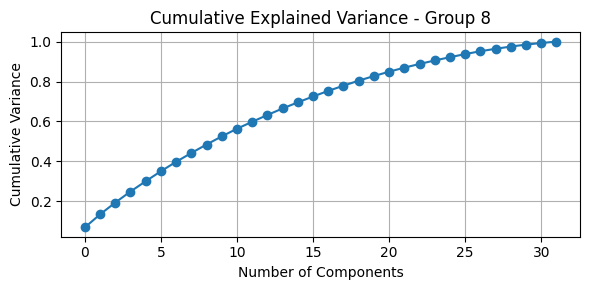

In [33]:
# After eigvals and eigvecs are sorted
explained_var_ratio = eigvals[sorted_indices] / np.sum(eigvals)

plt.figure(figsize=(6, 3))
plt.plot(np.cumsum(explained_var_ratio), marker='o')
plt.title(f'Cumulative Explained Variance - Group {g+1}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


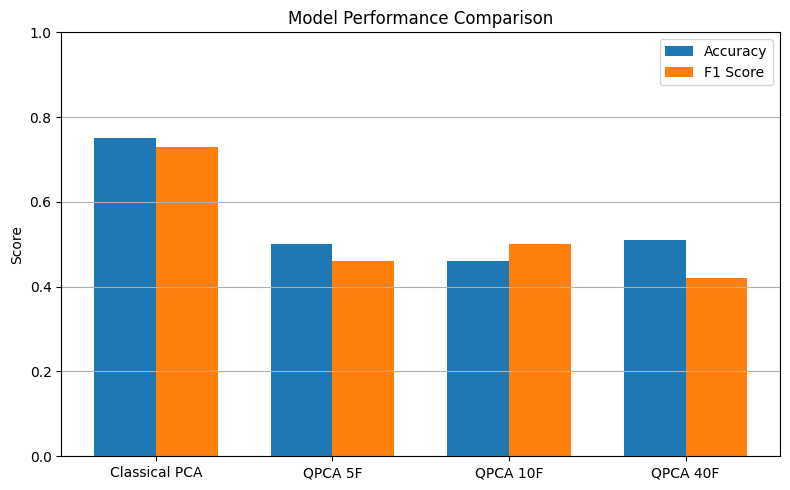

In [34]:
# Create performance bar chart
labels = ['Classical PCA', 'QPCA 5F', 'QPCA 10F', 'QPCA 40F']
accuracy_scores = [0.75, 0.50, 0.46, 0.51]
f1_scores = [0.73, 0.46, 0.50, 0.42]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, accuracy_scores, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='F1 Score')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


- QPCA can effectively compress quantum state information into real-valued features usable by classical ML models.

- Grouped QPCA enables scaling to high-dimensional inputs using only 5–6 qubits per group.
While quantum encoding was limited for simulation to 5, we solved it by grouping them. Efficient, scalable compression of 40 features → 24 QPCA features using only 5 qubits per group.

- While classical PCA achieved higher classification performance, the hybrid QPCA pipeline performed comparably when applied to all 40 features, showing potential for quantum pre-processing in future industrial ML systems.

- More inputs, more useful information can be extracted.

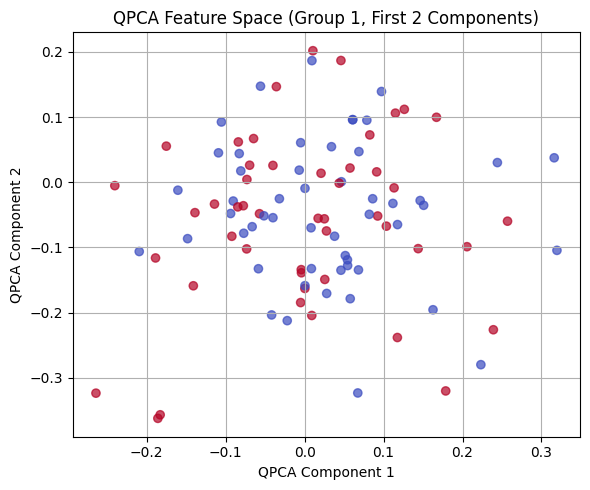

In [35]:
plt.figure(figsize=(6, 5))
plt.scatter(qpca_features_list[0][:, 0], qpca_features_list[0][:, 1], c=y_train[:num_samples], cmap='coolwarm', alpha=0.7)
plt.title("QPCA Feature Space (Group 1, First 2 Components)")
plt.xlabel("QPCA Component 1")
plt.ylabel("QPCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Quantum Circuit Simulation vs Real Quantum Execution

Also: Test whether using QPCA as a quantum feature reduction step, combined with classical classifiers like XGBoost or SVM, performs better than using logistic regression alone. 

If quantum components improve model performance.